In [35]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import Scorer

warnings.filterwarnings("ignore")

## Data Generation Process

Here we use a data generation process implemented by EconML for IV models and described as follows:

We construct the DGP as below. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability depends on both the observed feature $X$ and an unobserved confounder that has a direct effect on the outcome


\begin{align}
W \sim \; & \text{Normal}(0,\, I_{n_w})   \tag{Observed confounders}\\
Z \sim \; & \text{Bernoulli}(p=0.5)   \tag{Instrument}\\
\nu \sim \; & \text{U}[0, 5] \tag{Unobserved confounder}\\
C \sim \; & \text{Bernoulli}(p=0.8 \cdot \text{Sigmoid}(0.4 \cdot X[0] + \nu))   \tag{Compliers when recommended}\\
C0 \sim \; & \text{Bernoulli}(p=0.006)   \tag{Non-Compliers when not recommended}\\
T = \; & C \cdot Z + C0 \cdot (1-Z)  \tag{Treatment}\\
y \sim \; & \theta \cdot T + 2 \cdot \nu + 5 \cdot (X[3]>0) + 0.1 \cdot \text{U}[0, 1]  \tag{Outcome}
\end{align}


In [46]:
def iv_dgp_econml(n=5000, p=10, true_effect=10):

    X = np.random.normal(0, 1, size=(n, p))
    Z = np.random.binomial(1, 0.5, size=(n,))
    nu = np.random.uniform(0, 5, size=(n,))
    coef_Z = 0.8
    C = np.random.binomial(
        1, coef_Z * special.expit(0.4 * X[:, 0] + nu)
    )  # Compliers when recomended
    C0 = np.random.binomial(
        1, 0.006 * np.ones(X.shape[0])
    )  # Non-compliers when not recommended
    T = C * Z + C0 * (1 - Z)
    y = (
        true_effect(X) * T
        + 2 * nu
        + 5 * (X[:, 3] > 0)
        + 2.5 * np.random.uniform(0, 1, size=(n,))
    )
    cov = [f"x{i}" for i in range(1, X.shape[1] + 1)]
    df = pd.DataFrame(X, columns=cov)

    df["y"] = y
    df["treatment"] = T
    df["Z"] = Z

    return df

In [47]:
# Dataset parameters
treatment = "treatment"
targets = ["y"]
instruments = ["Z"]
outcome = targets[0]

### Model Fitting (1): Constant Effect (ATE)

We define a constant treatment effect (ATE) to be searched by the auto-causality tool for all named IV estimators.

\begin{align}
\theta = \; & 7.5 \tag{ATE}\\
\end{align}

In [48]:
TRUE_EFFECT = 6.7

CONSTANT_EFFECT = lambda X: TRUE_EFFECT

data = iv_dgp_econml(n=30000, p=10, true_effect=CONSTANT_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    data, treatment, targets, instruments
)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.33, random_state=123)

Xtest_constant_te = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,random
16419,0.0,9.238960,1.0,1.067054,0.714385,-0.352962,-1.158768,-0.366009,0.165191,-2.107107,-1.751100,0.838383,2.028967,0.0
8558,1.0,13.442729,1.0,-3.575646,1.107023,-1.105476,-1.156808,-1.305229,-1.595064,1.596803,-1.171648,-1.009889,-1.612392,0.0
425,0.0,6.070279,0.0,0.418005,-1.346856,2.028741,-0.238332,0.991197,0.588821,-1.832830,0.729557,-0.422247,0.595469,1.0
14858,1.0,15.816544,1.0,0.748353,0.364992,0.833615,1.243441,1.502731,0.147918,1.168043,0.354507,0.364360,0.892047,1.0
22689,0.0,7.796337,0.0,-1.059137,1.306717,1.245507,-0.749604,-0.860559,0.296209,1.565199,0.059622,-1.465361,-0.068036,1.0


For each treatment effect example, we fit a list of 6 IV models, scoring them with an energy distance score. The dataset is split into train, validation and a hold-out test set, and we report scores for each.

As a baseline we use dowhy's simple IV estimator, implementing Ward's estimator and two-stage least squares (2SLS)
The other estimators are implemented by EconML with details [here](https://econml.azurewebsites.net/reference.html#instrumental-variable-cate-estimators)

The components time budget represent tuning budget allocated to each estimator model.

In [39]:
estimator_list = ["SimpleIV", "SparseLinearDRIV", "DMLIV", "OrthoIV", "LinearDRIV", "LinearIntentToTreatDRIV", "ForestDRIV", "IntentToTreatDRIV"]

In [42]:
ac_constant_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    time_budget=14400,
    components_time_budget=300,
    propensity_model="auto",
    train_size=0.5
)

ac_constant_te.fit(train_df, treatment, outcome, features_W, features_X, instruments)


 We get the estimated effect for the best estimator by energy distance score

In [40]:
# score all estimators on the test set
def score_all_test(models, test_set):
    for est_name, scr in models.scores.items():
        try:
            causal_estimate = scr['estimator']
            # print(causal_estimate.estimator._treatment_name)
            scr['scores']['test'] = models.scorer.make_scores(
                causal_estimate,
                test_set,
                problem=models.problem,
                metrics_to_report=models.metrics_to_report
            )
        except Exception as e:
            print(e)
            pass


def ate_mse(scores, true_effect=TRUE_EFFECT):
    return  [(v-true_effect)**2 for v in scores]


In [63]:
def get_est_effects(models, test_x, te=TRUE_EFFECT):
    est_scores = []
    for est_name, scr in models.scores.items():
        est_effect = scr["estimator"].estimator.effect(test_x).mean()
        energy_distance = scr["scores"]["test"]["energy_distance"]
        est_scores.append([est_name, est_effect, (est_effect-te)**2, energy_distance])

    return pd.DataFrame(est_scores, columns=["estimator", "estimated_effect", "ate_mse", "energy_distance"])


In [42]:
%matplotlib inline

def graph_compare_estimators(model):
    colors = ([matplotlib.colors.CSS4_COLORS['black']] +
        list(matplotlib.colors.TABLEAU_COLORS) + [
        matplotlib.colors.CSS4_COLORS['lime'],
        matplotlib.colors.CSS4_COLORS['yellow'],
        matplotlib.colors.CSS4_COLORS['pink']
    ])


    plt.figure(figsize = (7,5))
    plt.title(outcome)

    m1 = "energy_distance"
    m2 = "ate"

    splits =  ["train", "validation", "test"]

    for (est, scr), col in zip(model.scores.items(), colors):
        try:
            scores  = scr["scores"]
            sc = [scores[v][m1] for v in splits]
            crv = ate_mse([scores[v][m2] for v in splits])
            plt.plot(sc, crv, color=col, marker="o", label=est)
            plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
            plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

        except Exception as e:
            print(e)
            pass

    plt.xlabel(m1)
    plt.ylabel(f"{m2}_MSE")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

    plt.grid()
    plt.show()


First we see the estimated effect for each model, and respective MSE compared with true effect

In [23]:
get_est_effects(ac_constant_te, Xtest_constant_te)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,7.326025,0.030267
1,iv.econml.iv.dml.DMLIV,3.608027,15.147457
2,iv.econml.iv.dml.OrthoIV,7.382694,0.013761
3,iv.econml.iv.dr.ForestDRIV,3.201586,18.476363
4,iv.econml.iv.dr.IntentToTreatDRIV,9.685034,4.774375
5,iv.econml.iv.dr.LinearDRIV,3.647634,14.840727
6,iv.econml.iv.dr.SparseLinearDRIV,5.312383,4.785668


In the plots we show the energy distance scores on the train, validation and hold-out test sets compared with the mean squared error between estimated effect and the true effect

In [55]:
# Get non-optimal runs from each estimator and score on (energy distance, ate)
# ac_constant_te.results.results

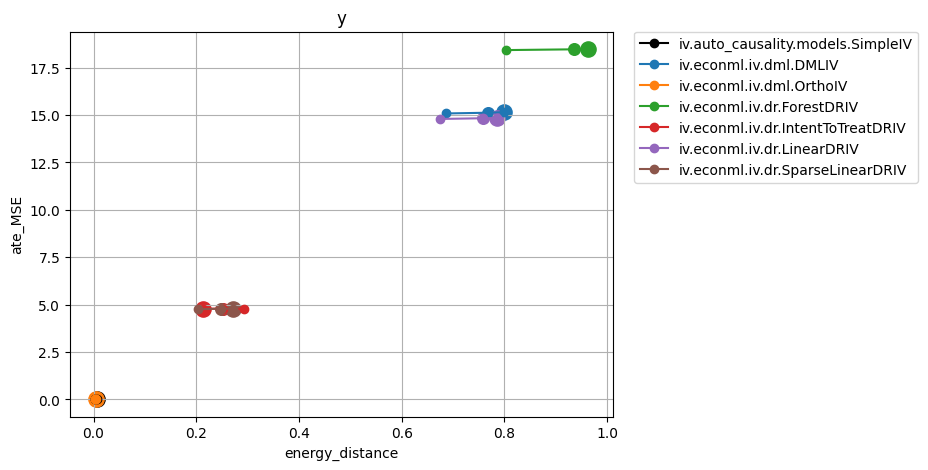

In [24]:
score_all_test(ac_constant_te, test_df)
graph_compare_estimators(ac_constant_te)

### Model Fitting (2): Heterogeneous Treatment Effect

Here we replace the constant treatment effect with a linear treatment effect function of some covariates  to estimate heterogeneous effects.

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}

In [51]:
LINEAR_EFFECT = lambda X: TRUE_EFFECT * (X[:, 0] ** 2) * (X[:, 1])

synth_data = iv_dgp_econml(n=60000, p=15, true_effect=LINEAR_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    synth_data, treatment, targets, instruments
)
df_train, df_test = train_test_split(data_df, test_size=0.3)

# Xtest_le = data_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,random
16419,0.0,9.238960,1.0,1.067054,0.714385,-0.352962,-1.158768,-0.366009,0.165191,-2.107107,-1.751100,0.838383,2.028967,0.0
8558,1.0,13.442729,1.0,-3.575646,1.107023,-1.105476,-1.156808,-1.305229,-1.595064,1.596803,-1.171648,-1.009889,-1.612392,0.0
425,0.0,6.070279,0.0,0.418005,-1.346856,2.028741,-0.238332,0.991197,0.588821,-1.832830,0.729557,-0.422247,0.595469,1.0
14858,1.0,15.816544,1.0,0.748353,0.364992,0.833615,1.243441,1.502731,0.147918,1.168043,0.354507,0.364360,0.892047,1.0
22689,0.0,7.796337,0.0,-1.059137,1.306717,1.245507,-0.749604,-0.860559,0.296209,1.565199,0.059622,-1.465361,-0.068036,1.0


In [91]:
data_df[data_df.treatment == 1]

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
0,1.0,-5.857266,1.0,-0.956795,-1.178507,-1.129198,-0.645068,0.167830,0.348441,0.851846,-1.081505,0.581587,-0.574253,-1.368989,0.272100,-1.573310,-0.507589,-0.956977,0.0
1,1.0,7.517274,1.0,-0.138869,-0.249410,-0.584851,-0.357059,0.079235,-1.901374,-0.535228,1.463549,-0.268117,-0.108965,0.231877,0.389894,0.514196,-0.335019,1.128440,0.0
4,1.0,25.041063,1.0,1.454705,0.641983,0.014713,0.562378,-0.634927,-0.972242,-1.063038,1.945098,1.032618,0.557545,-1.115065,-0.490879,-0.269849,0.106047,0.457152,1.0
8,1.0,26.797527,1.0,1.485008,1.027758,0.976465,1.734990,-0.602963,0.640304,-0.254952,-0.691510,1.235951,-0.068268,-1.961152,0.426090,0.190600,1.279662,0.232079,0.0
10,1.0,6.337119,1.0,-0.145518,0.458297,1.303044,-1.513008,0.350095,2.154975,-0.109683,0.945298,-1.109862,1.580630,0.660332,-0.045244,1.111304,-0.022584,0.328517,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59983,1.0,0.362284,1.0,-1.631940,-0.595259,0.713877,-0.180002,0.899401,-1.589265,-0.328404,-0.379493,0.090674,0.396572,-1.081569,-0.190047,0.755182,-1.510724,-0.485738,0.0
59984,1.0,2.877093,1.0,-1.197097,-0.654452,0.996159,-1.869497,-0.351468,-0.690206,1.449985,-0.176614,0.211116,1.852252,-0.583796,1.101536,-1.480567,1.227870,-0.673992,0.0
59990,1.0,-10.123417,1.0,1.586672,-1.050485,0.743416,-0.416742,-0.805173,2.293855,0.593365,-0.332352,-0.071193,1.154639,1.306584,0.859916,-0.252670,0.948550,-0.813228,0.0
59992,1.0,6.976418,1.0,-1.620430,-0.328588,1.342052,1.363952,-0.432463,-0.570164,-2.305030,0.533703,-0.128929,0.704356,-0.112109,-1.587572,-0.014723,0.326216,0.894774,1.0


In [53]:
ac_linear_te = AutoCausality(
    estimator_list=["SimpleIV", "SparseLinearDRIV", "DMLIV", "OrthoIV", "LinearDRIV", "LinearIntentToTreatDRIV", "ForestDRIV", "IntentToTreatDRIV"],
    verbose=3,
    components_verbose=2,
    time_budget=28800,
    components_time_budget=1200,
    propensity_model="auto",
    train_size=0.8
)

ac_linear_te.fit(df_train, treatment, outcome, features_X[2:], features_X[:2], instruments)

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 09-26 13:44:47] {375} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-26 13:44:47] {506} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}


Initial configs: [{'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.IntentToTreatDRIV', 'opt_reweighted': 0, 'cov_clip': 0.1, 'prel_opt_reweighted': 1, 'prel_cate_approach': 'driv'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.ForestDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1, 'min_samples_split': 2}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
[flaml.tune.tune: 09-26 13:45:11] {118} INFO - result: {'energy_distance': 0.22867408617253382, 'estimator_name': 'iv.auto_causality.models.SimpleIV', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x169816820>, 'ate': 0.12512341141700745, 'ate_std': 0.0, 'energy_distance': 0.193058835931172}, 'validation': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x16b5fc0d0>, 'ate': 0.12512341141700745, 'ate_std': 0.0, 'energy_distance': 0.22867408617253382}}, 'config'

In [93]:
data_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
0,1.0,-5.857266,1.0,-0.956795,-1.178507,-1.129198,-0.645068,0.167830,0.348441,0.851846,-1.081505,0.581587,-0.574253,-1.368989,0.272100,-1.573310,-0.507589,-0.956977,0.0
1,1.0,7.517274,1.0,-0.138869,-0.249410,-0.584851,-0.357059,0.079235,-1.901374,-0.535228,1.463549,-0.268117,-0.108965,0.231877,0.389894,0.514196,-0.335019,1.128440,0.0
2,0.0,10.481343,0.0,0.545352,-0.955324,1.477746,-0.165268,0.528634,-1.316319,1.866381,1.742396,-0.155441,0.188968,-0.010739,-0.078663,-0.094124,2.316504,-0.441800,1.0
3,0.0,7.467568,0.0,0.353114,-0.659324,-0.410153,0.607940,1.724601,0.421766,-2.016214,1.653721,1.596158,-0.945855,2.026967,-0.023056,-0.297506,-0.042055,1.162182,1.0
4,1.0,25.041063,1.0,1.454705,0.641983,0.014713,0.562378,-0.634927,-0.972242,-1.063038,1.945098,1.032618,0.557545,-1.115065,-0.490879,-0.269849,0.106047,0.457152,1.0


In [94]:
ate = (
    data_df[data_df.treatment == 0]["y"].mean() - 
    data_df[data_df.treatment == 1]["y"].mean()
)
ate

-0.83471394

In [89]:
from cProfile import label


def get_scores(results_dict, te=TRUE_EFFECT):
    all_scores = list()
    for label, scores in results_dict.items():
        val_scores = scores["scores"]["validation"]
        ate = val_scores["ate"]
        energy_distance = val_scores["energy_distance"]
        all_scores.append([energy_distance, (te-ate)**2])
    return all_scores


def all_estimator_scatter(results, best_estimators, title):
    all_scores = get_scores(results)
    best_scores = get_scores(best_estimators)
    estimators = list(best_estimators.keys())

    fig, ax = plt.subplots(figsize=(9, 7))
    
    for est in all_scores:
        ax.scatter(est[1], est[0], c="gray", label="_nolegend_")
    for i, est in enumerate(best_scores):
        print(est)
        ax.scatter(est[1], est[0], label=estimators[i])
    
    ax.set_ylabel("test score")
    ax.set_xlabel("MSE")
    ax.set_title("energy_distance")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.show()

Here, we compare the best run(s) - orange dots - for the selected estimator(s), compared with intermediate runs - grey dots.

[0.22867408617253382, 43.22900215509673]
[0.14344045826186225, 44.243809829795076]
[0.21031591646680425, 44.18064106937167]
[0.013732010545933093, 43.309065467755715]
[0.1581589010732456, 44.38416319592103]


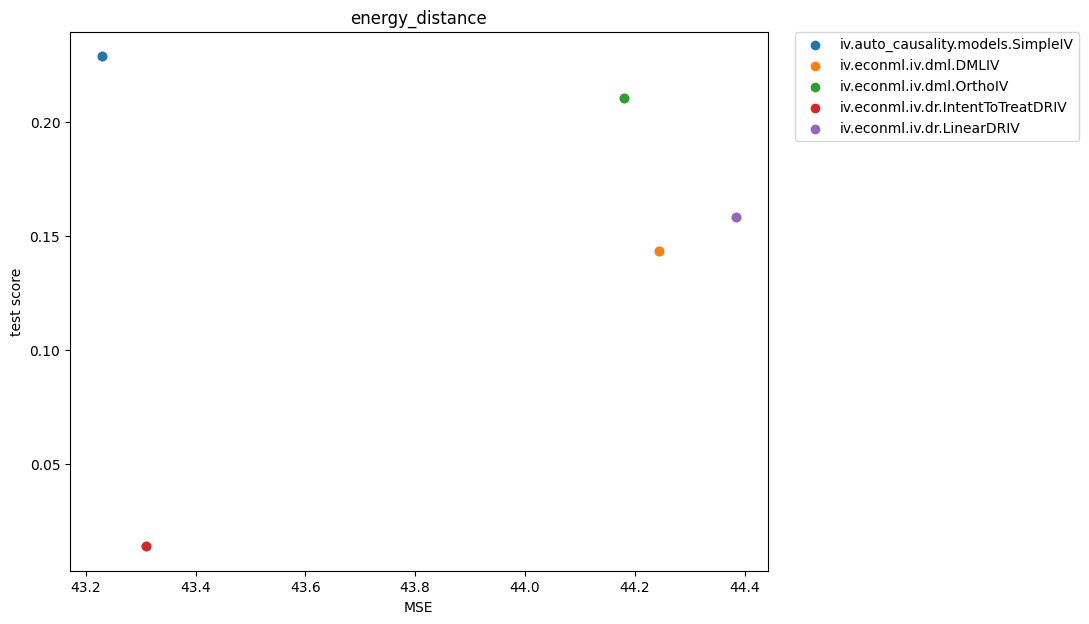

In [90]:
all_estimator_scatter(
    ac_linear_te.results.results,
    ac_linear_te.scores,
    title="linear_cate"
)

In [140]:
import numpy as np

def mse_heffects(estimator, test_cov, labels):
    est_effect = estimator.effect(test_cov)
    print("Estimated effect")
    print(est_effect)
    print("Known")
    print(labels)
    print()
    mse = np.square(est_effect - labels).mean()
    
    return mse

In [139]:
df_test[['x1', 'x2']].values.shape

CATE_VALUES = lambda x, y: TRUE_EFFECT * (x ** 2) * y
test_covals = df_test[['x1', 'x2']].values
x, y = test_covals[:, 0], test_covals[:, 1]
cate_effect_vals = CATE_VALUES(x, y)

In [111]:
LINEAR_EFFECT(df_test.values)

array([   0.     ,  -97.23335, -175.84822, ...,    0.     ,    0.     ,
          0.     ], dtype=float32)

In [141]:
stats = []
for est_name, scr in ac_linear_te.scores.items():
    print(est_name)
    estimator = scr["estimator"].estimator
    
    # mse_train = mse_heffects(estimator, df_train[features_X[:2]], df_train.y)
    mse_test = mse_heffects(estimator, df_test[features_X[:2]], cate_effect_vals)

    energy_distance = ac_linear_te.scorer.make_scores(
                scr["estimator"],
                df_test,
                problem=ac_linear_te.problem,
                metrics_to_report=ac_linear_te.metrics_to_report
            )["energy_distance"]
    

    stats.append([est_name, mse_test, energy_distance])
   

iv.auto_causality.models.SimpleIV
Estimated effect
[0.12512341 0.12512341 0.12512341 ... 0.12512341 0.12512341 0.12512341]
Known
[-5.4438931e-01 -2.1898376e+01 -3.4319511e+01 ...  2.8000344e-03
  7.8096194e+00 -1.7751014e-01]

iv.econml.iv.dml.DMLIV
Estimated effect
[-0.1401385  -3.58436614 -5.40976472 ...  4.35288413  1.13125824
 -0.87956819]
Known
[-5.4438931e-01 -2.1898376e+01 -3.4319511e+01 ...  2.8000344e-03
  7.8096194e+00 -1.7751014e-01]

iv.econml.iv.dml.OrthoIV
Estimated effect
[ -0.27834495  -7.74341839 -11.61187065 ...   9.16999275   2.24269859
  -1.89502179]
Known
[-5.4438931e-01 -2.1898376e+01 -3.4319511e+01 ...  2.8000344e-03
  7.8096194e+00 -1.7751014e-01]

iv.econml.iv.dr.IntentToTreatDRIV
Estimated effect
[  1.35708627 -28.65912597 -31.54220503 ...  -0.12614895   8.96411106
   0.40834286]
Known
[-5.4438931e-01 -2.1898376e+01 -3.4319511e+01 ...  2.8000344e-03
  7.8096194e+00 -1.7751014e-01]

iv.econml.iv.dr.LinearDRIV
Estimated effect
[-0.32245121 -5.54777866 -8.4018117

In [117]:
get_est_effects(ac_linear_te, df_test[features_X[:2]])

,estimator,estimated_effect,ate_mse,energy_distance
0,iv.auto_causality.models.SimpleIV,0.125123,43.229002,0.208813
1,iv.econml.iv.dml.DMLIV,0.031996,44.462276,0.130863
2,iv.econml.iv.dml.OrthoIV,0.017911,44.650307,0.199842
3,iv.econml.iv.dr.IntentToTreatDRIV,0.024849,44.557638,0.011017
4,iv.econml.iv.dr.LinearDRIV,0.012671,44.720370,0.148137


In [126]:
ac_linear_te.scores['iv.econml.iv.dml.DMLIV']['estimator'].estimator.effect_interval(None)

AttributeError: 'Econml' object has no attribute 'effect_interval'

In [147]:
ac_linear_te.estimator_list

['iv.auto_causality.models.SimpleIV',
 'iv.econml.iv.dml.DMLIV',
 'iv.econml.iv.dml.OrthoIV',
 'iv.econml.iv.dr.ForestDRIV',
 'iv.econml.iv.dr.IntentToTreatDRIV',
 'iv.econml.iv.dr.LinearDRIV',
 'iv.econml.iv.dr.LinearIntentToTreatDRIV',
 'iv.econml.iv.dr.SparseLinearDRIV']

IndexError: index 2 is out of bounds for axis 0 with size 2

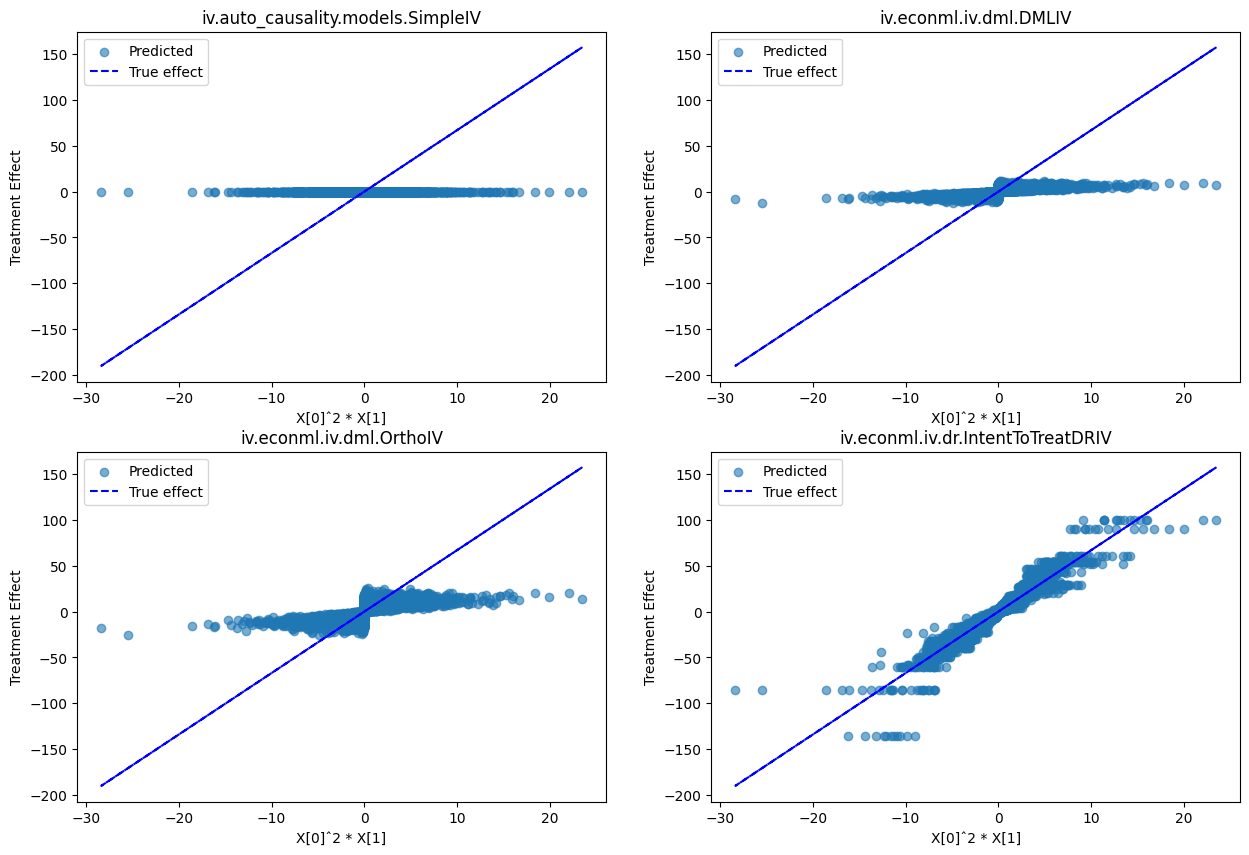

In [155]:
%matplotlib inline

LINEAR_EFFECT_Z = lambda X: TRUE_EFFECT  * ((X.values[:, 0] ** 2) * X.values[:, 1])
excl = [
    'iv.econml.iv.dr.ForestDRIV', 
    'iv.econml.iv.dr.LinearIntentToTreatDRIV',
    'iv.econml.iv.dr.SparseLinearDRIV'
]
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
i, j = 0, 0
for est in ac_linear_te.estimator_list:
    if est not in excl:
        X_test = df_test[features_X[:2]]
        estimator = ac_linear_te.scores[est]['estimator']
        te_pred1 = estimator.estimator.effect(X_test)

        xval = ((X_test.values[:, 0] ** 2) * X_test.values[:, 1])
        ax[i][j].scatter(xval, te_pred1, label="Estimated effect", alpha=0.6)
        ax[i][j].plot(xval, LINEAR_EFFECT_Z(X_test), "b--", label="True effect")
        ax[i][j].set_xlabel("X[0]ˆ2 * X[1]")
        ax[i][j].set_ylabel("Treatment Effect")
        ax[i][j].set_title(est)
        ax[i][j].legend()

        j = (j+1) % 2
        if j == 0:
            i += 1

plt.show()

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                           -1⎤
 ⎢ d      ⎛ d               ⎞  ⎥
E⎢────(y)⋅⎜────([treatment])⎟  ⎥
 ⎣d[Z]    ⎝d[Z]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{treatment}, then ¬({Z}→y)

## Realized estimand
b: y~treatment+x3+x8+x10+x7+x12+x14+x13+x9+x4+x6+x5+x15+x11 | x1,x2
Target units: ate

## Estimate
Mean value: -0.004855545825924427
Effect estimates: [-0.21967612  0.77514718 -4.90476635 ...  0.56938301  4.68878718
  2.44591372]



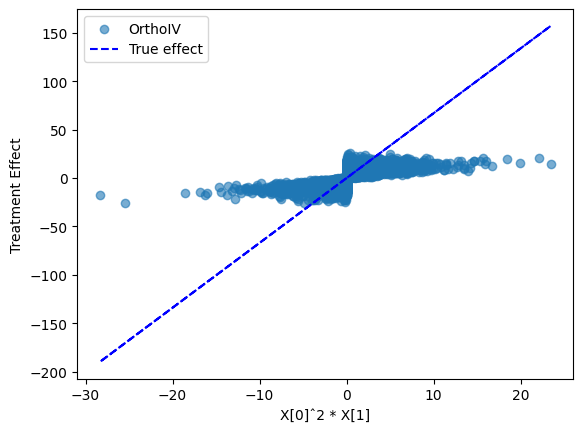

In [128]:
%matplotlib inline

LINEAR_EFFECT_Z = lambda X: TRUE_EFFECT  * ((X.values[:, 0] ** 2) * X.values[:, 1])

for est, est_name in zip(
        [ac_linear_te.scores['iv.econml.iv.dml.OrthoIV']['estimator']],
        ["OrthoIV"],
    ):
    X_test = df_test[features_X[:2]]
    te_pred1 = est.estimator.effect(X_test)
    # te_pred1_lb, te_pred1_ub = est.estimator.effect_interval(X_test, alpha=0.05)

    xval = ((X_test.values[:, 0] ** 2) * X_test.values[:, 1])
    plt.scatter(xval, te_pred1, label=est_name, alpha=0.6)
    # plt.fill_between(xval, te_pred1_lb, te_pred1_ub, alpha=0.4)
    plt.plot(xval, LINEAR_EFFECT_Z(X_test), "b--", label="True effect")
    # plt.scatter(xval, LINEAR_EFFECT_Z(X_test), label="True effect")
    plt.xlabel("X[0]ˆ2 * X[1]")
    plt.ylabel("Treatment Effect")
    plt.legend()
    plt.show()

[Text(0.5, 0, 'MSE(TRUE_CATE, PRED_CATE)'), Text(0, 0.5, 'ENERGY_DISTANCE')]

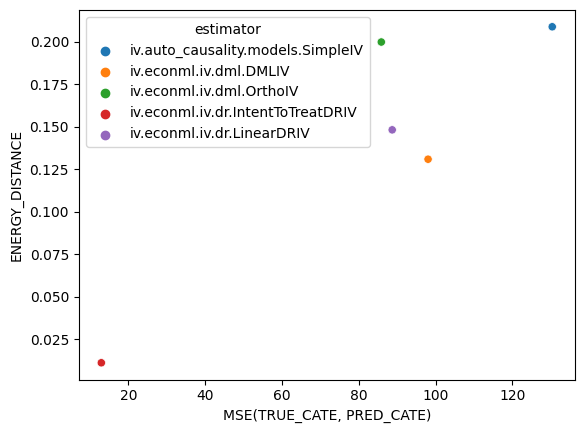

In [146]:
import seaborn as sns

df_stats = pd.DataFrame(stats, columns=["estimator", "mse", "energy_distance"])
g = sns.scatterplot(
    df_stats,
    x="mse",
    y="energy_distance",
    hue="estimator"
)
g.set(xlabel="MSE(TRUE_CATE, PRED_CATE)", ylabel="ENERGY_DISTANCE")

In [64]:
Xtest = test_df[features_X[:2]]
get_est_effects(ac_linear_te, Xtest)

,estimator,estimated_effect,ate_mse,energy_distance
0,iv.auto_causality.models.SimpleIV,0.125123,43.229002,0.208813
1,iv.econml.iv.dml.DMLIV,-0.017493,45.124719,0.130863
2,iv.econml.iv.dml.OrthoIV,-0.086598,46.057914,0.199842
3,iv.econml.iv.dr.IntentToTreatDRIV,-0.026285,45.242911,0.011017
4,iv.econml.iv.dr.LinearDRIV,-0.065063,45.766084,0.148137


In [60]:
score_all_test(ac_linear_te, df_test)
get_est_effects(ac_linear_te, Xtest)
graph_compare_estimators(ac_linear_te)

KeyError: 'test'

In [66]:
import pickle

with open("8h_80K.pkl", "wb") as f:
    pickle.dump(ac_linear_te, f)

AttributeError: Can't pickle local object 'AutoCausality.fit.<locals>.<lambda>'

### Model Fitting (3): Non-linear Heterogeneous Treatment Effect

Finally we explore non-linear heterogeneous treatment effects with the function below:

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}


In [30]:
QUADRATIC_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] ** 2) * (X[:, 7] ** 3) 

data = iv_dgp_econml(n=10000, p=15, true_effect=QUADRATIC_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    data, treatment, targets, instruments
)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.3)
Xtest = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
1749,0.0,7.962746,0.0,-0.930624,1.162991,0.729456,-0.273677,0.689983,-0.542694,0.342018,-0.986162,0.334147,-0.522664,-0.760399,-0.696916,-0.250714,-0.925333,-0.308684,0.0
8753,0.0,7.466413,1.0,0.098788,0.561751,1.067532,-0.954808,0.157062,-1.942514,-1.290649,-1.146356,-0.172148,0.545423,-0.239812,-0.914031,-0.801335,2.295311,-2.074314,1.0
2376,0.0,3.807416,0.0,1.211798,0.320737,0.285181,-0.475356,1.627070,-0.820177,0.193067,-0.743845,0.394570,0.736218,0.934503,1.313644,1.574028,-1.220983,-0.814131,1.0
5866,0.0,12.620029,0.0,1.142354,0.262738,0.939899,0.564811,0.365819,0.764096,-1.760255,-0.410142,1.154539,-0.685998,0.255347,0.375952,-0.738155,-0.735688,0.734578,0.0
7097,0.0,13.829594,0.0,0.037404,-0.237903,-0.971907,1.921247,-1.191215,-0.365760,0.824570,-0.665056,0.294414,-0.598442,-1.346559,-0.393804,0.444747,-0.322192,1.439316,1.0


In [31]:
ac_quad_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=30,
    propensity_model="auto",
    train_size=0.8
)

ac_quad_te.fit(train_df, treatment, outcome, features_W, features_X, instruments)


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 09-20 22:45:29] {375} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-20 22:45:29] {506} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}


Initial configs: [{'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.IntentToTreatDRIV', 'opt_reweighted': 0, 'cov_clip': 0.1, 'prel_opt_reweighted': 1, 'prel_cate_approach': 'driv'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.ForestDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1, 'min_samples_split': 2}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
[flaml.tune.tune: 09-20 22:45:33] {118} INFO - result: {'energy_distance': 0.5016108513784632, 'estimator_name': 'iv.auto_causality.models.SimpleIV', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x1665569d0>, 'ate': -1.8753958940505981, 'ate_std': 0.0, 'energy_distance': 0.4150975522394269}, 'validation': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x166556b20>, 'ate': -1.8753958940505981, 'ate_std': 0.0, 'energy_distance': 0.5016108513784632}}, 'config':

In [33]:
get_est_effects(ac_quad_te, Xtest)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,-1.875396,87.898048
1,iv.econml.iv.dml.DMLIV,-0.545693,64.733176
2,iv.econml.iv.dml.OrthoIV,-0.907341,70.683388
3,iv.econml.iv.dr.IntentToTreatDRIV,-1.341814,78.177668
4,iv.econml.iv.dr.LinearDRIV,-0.406059,62.505762


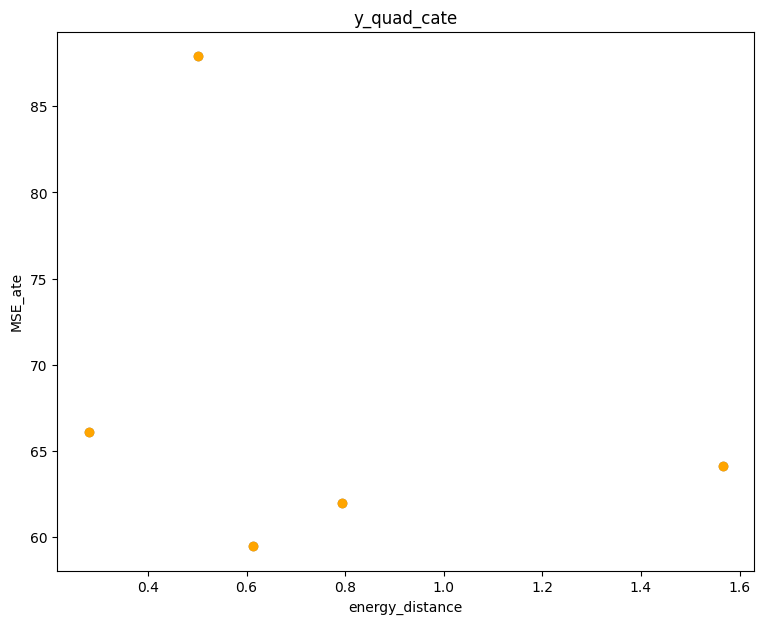

In [32]:
all_estimator_scatter(
    ac_quad_te.results.results,
    ac_quad_te.scores,
    title="quad_cate"
)

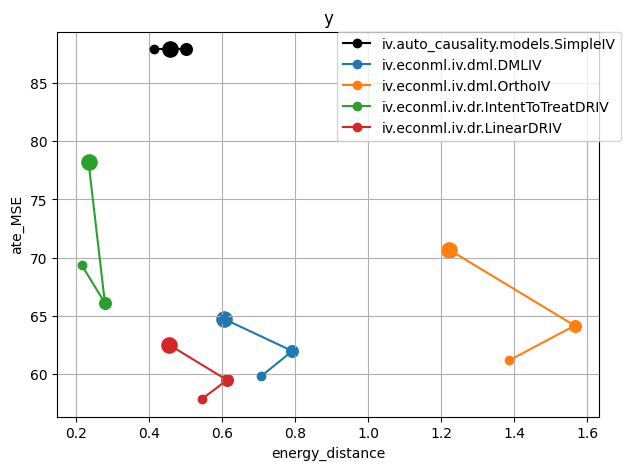

In [34]:
score_all_test(ac_quad_te, test_df)
graph_compare_estimators(ac_quad_te)
